# Learning how to build CNNs
## Based on Chap 14 of Hands on ML 3rd ed

In [15]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
np.random.seed(0)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

In [2]:
# To plot grayscale and RGB images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

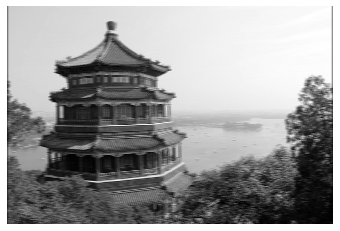

In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
# Line filters are 7x7 matrices, channels for RGB or grayscale and 2 for the 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# images is the inpur mini batch (4D tensor), filters (also 4D tensor), 
#strides for size reduction, here 1 but could also be 1D array with 4 elements with strides(1, s_h, s_w, 1), used to skip some instances or some of previous layers feature maps or channels
# padding either same (add zero paddings) or valid (ignore some rows depending on stride)
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

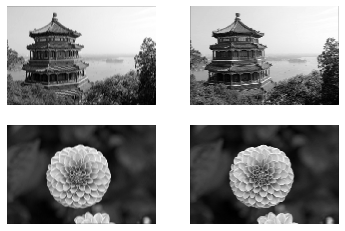

In [8]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

To see better as cropped

In [3]:

def crop(images):
    return images[150:220, 130:250]

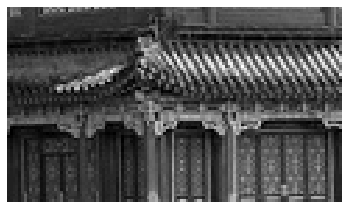

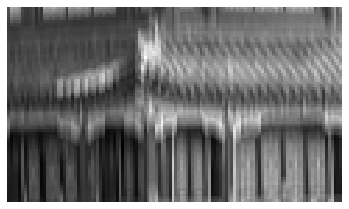

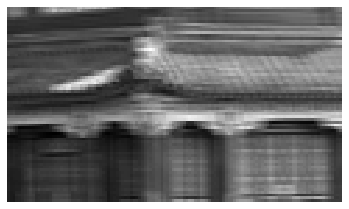

In [10]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

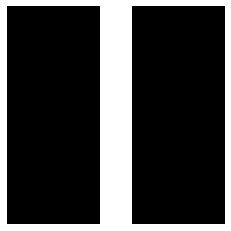

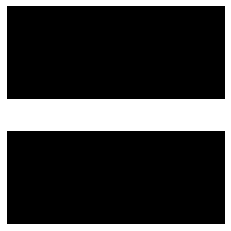

In [11]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### In a real CNN wouldn't define filters manually but as trainable variables

In [12]:
# Convolutional layer in keras - need to choose number of filters, height, width, strides, padding
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

# Training requires lots of RAM. If training crashes because out of memory - reduce the mini batch size, reduce dimensionality using stride, or remove a few layers. Or distribute CNN across multiple devices

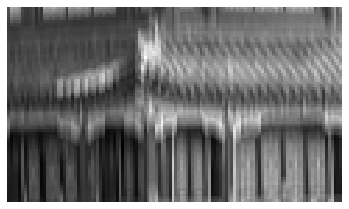

In [13]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

### Pooling Layer
1. Goal is to subsample the input image to reduce computational load, memory usage, number of parameters.
2. Each neuron connected with outputs of a limited number of neurons in previous layer, located within a small rectangular receptive field
3. Size, stride and padding type. No weights, aggregates the inputs using sum, max or mean etc
4. Most common - max pooling layer, only max of inputs makes it to next layer
5. Also introduces some level of invariance to small translations
6. By introducing max pooling every few layers can get some level of translational invariance at a larger scale, and some rotational and scale invariance, useful in classification tasks.

In [14]:
# create max pooling layer using 2x2 kernel. strides default to kernel size with VALID padding (no padding)
# Average pooling layer - AvgPool2D
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [15]:
# Using max_pool on cropped image
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

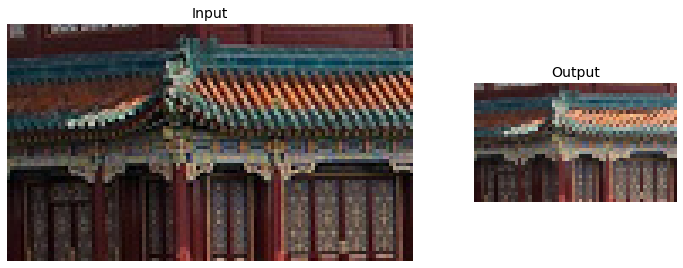

In [17]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Depth-wise max pooling - invariance to stuff like rotation and color

In [18]:
# No keras implementation, can define own keras layer
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [19]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [20]:
# Or using a Lambda function
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

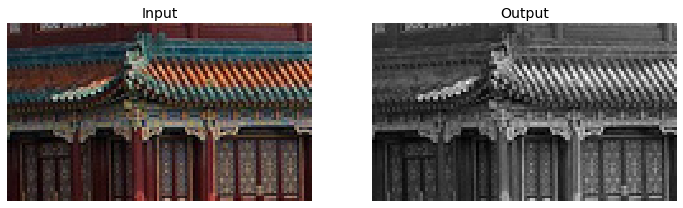

In [21]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [22]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

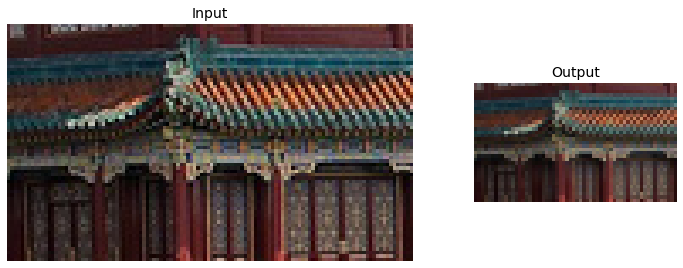

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global average pooling
1. Computes the mean of each feature map
2. Loses most of the information of the figure, but can be useful as output layer

In [24]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=74, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [25]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=77, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## Fashion MNIST with CNN
Typical CNN - Convolution, ReLU, pooling, repeat. image gets smaller and smaller but also deeper and deeper

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [13]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    # 64 7*7 fairly large filters, but no stride because small images. 28x28 pixels with single color channel (grayscale)
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    # Pool size of 2, divides each spatial dimension by a factor of 2
    keras.layers.MaxPooling2D(pool_size=2),
    # Repeat this 2 conv layers and 1 pool layer structure. Repeat several more times for larger images (hyperparameter)
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    # Flatten inputs to dense since it expects a 1D array of features for each instance
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    # Dropout layers prevent overfitting
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [14]:
# Can't finish running this without GPU but expected to reach 90+% accuracy, much more than earlier dense networks
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 512s 9ms/sample - loss: 0.6838 - accuracy: 0.7664 - val_loss: 0.3514 - val_accuracy: 0.8740
Epoch 2/10
 6272/55000 [==>...........................] - ETA: 7:38 - loss: 0.4314 - accuracy: 0.8609

KeyboardInterrupt: 

## LeNet 5 architecture
1. Input 32x32 (Actual 28*28 but padded and normalized). Rest of network doesn't use padding
2. Convolutio 5x5 kernel with stride 1 
3. Avg pooling 2x2 - more complex, each neuron computes mean of inputs and multiplies by learnable coefficient
4. Another conv c3 - connected to only 3 or 4 of 6 maps in s2, follwed by another pooling and conv
5. Fully connected layer of size 84
6. Output layer

## AlexNet
1. Similar to LeNet but much larger and deeper
2. First to stack conv layers instead of pooling after each conv
3. To control overfitting used dropout and data augmentation
4. Variant of AlexNet with tweaked hyperparameters - ZFNet

## GoogLeNet
1. Similar to LeNet but much larger and deeper, from google research
2. Use subnetworks called inception modules - allow more efficient parameter usage
3. Each pair of convolutional networks acts as single powerful convolutional layer
4. Inception modules are interleaved with some max pooling layers to reduce dimensionality and speed up the net
5. Global average pooling layer reduces dimensionality- no need for several fully connected layers like in AlexNet

## ResNet
1. Extremley deep CNNs with fewer and fewer parameters
2. Use skip connections (shortcuts), input of layer also fed into a layer higher up
3. If connection is skipped, it's forced to model residual of input. If target function fairly close to identity function, speed up training considerably. Also different parts of network can learn in parallel. can be seen as a stack of residual units

### ResNet architecture using Keras

In [6]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [7]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [8]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

## Using pre-trained models

In [9]:
# loads a resnet50 with pretrained weights
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 4s 0us/step


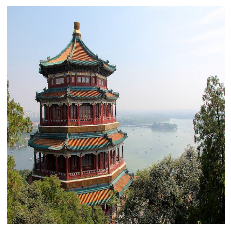

In [12]:
# Resnet50 expects 224x224 images - use tf.image.resize
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


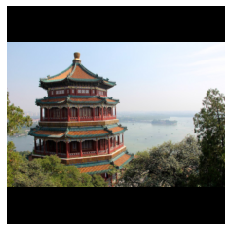

In [13]:
# Other ways of resizing
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

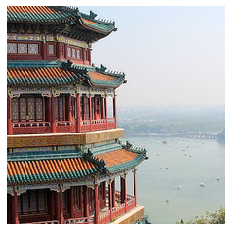

In [14]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

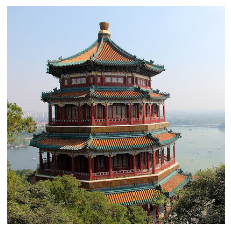

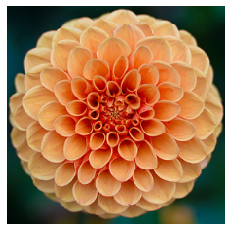

In [15]:
# If know how to crop
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [16]:
# Preprocess inputs based on model. could be 0 to 1 or -1 to 1 etc. Turn pixels back to 0-255
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [17]:
Y_proba.shape

(2, 1000)

In [18]:
# Top k classes of predictions for these 2 images
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 1us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [19]:
# Top k classes of predictions for these 2 images
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=4)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%
  n02980441 - castle       0.81%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%
  n03443371 - goblet       3.84%



## Using pretrained model lower layers
Good when less training data

In [5]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [6]:
# Can get info about dataset
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [7]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [8]:

class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [9]:
n_classes = info.features["label"].num_classes

In [10]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [11]:
# Load with train test split
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

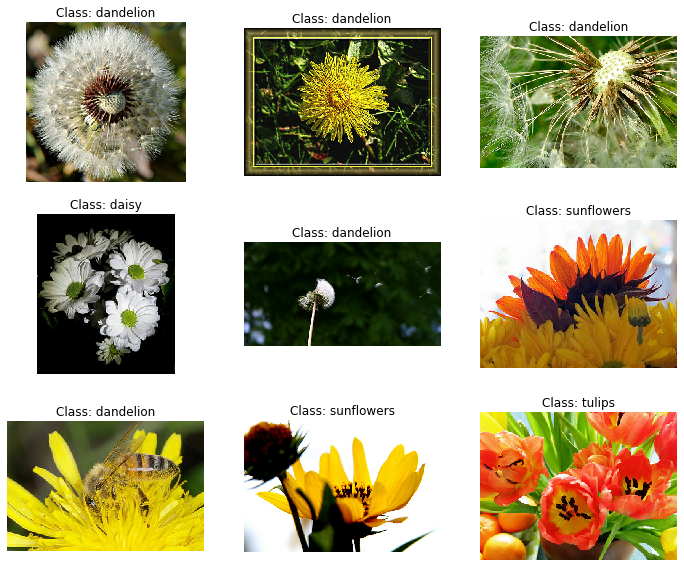

In [12]:
# These datasets are iterables
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### Basic preprocessing

In [13]:
def preprocess(image, label):
    # Resize and run through the preprocess function of the CNN
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label### Basic preprocessing

### Fancier preprocessing
Could add more data augmentation

In [16]:
# Crop the image in a certain way
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

# Randomly crop the image
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        # flip the images left and right randomly
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# Add batching and prefetching
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

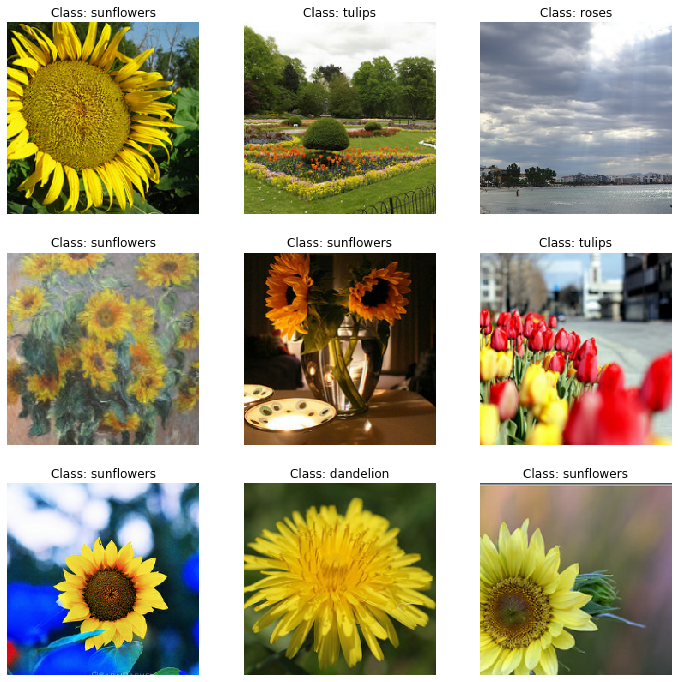

In [17]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

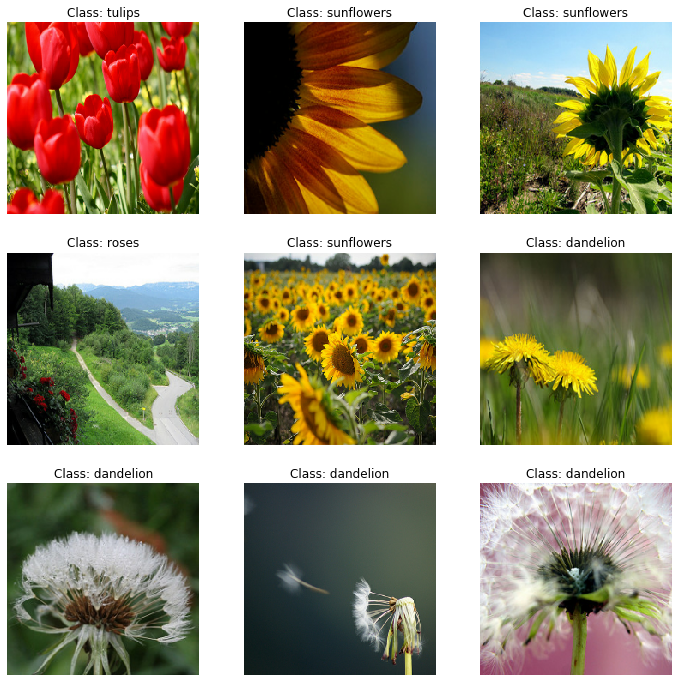

In [19]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [42]:
# Load an Xception model, exclude the top layer (excludes global average pooling layer and dense output layer)
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# Add our own global average pooling layer and dense output layer of size n_classes
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 3s 0us/step


In [43]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_36
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_37
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_38
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [44]:
# Set the pretrained model layers as untrainable and fit the final pooling and output layer. good idea to freeze these layers, at least in beginning of training
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
 5/86 [>.............................] - ETA: 33:44 - loss: 1.5497 - accuracy: 0.4531

KeyboardInterrupt: 

In [ ]:
# After training for a few epochs, unfreeze the layers, or just the top ones and continue training
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

### Can get up to 95% accuracy on classification
Next : where the flower is in the picture

# Localization
1. Done as a regression task, by making a bounding box around the object, or horizontal and vertical coordinates of center with height and width
2. 4 numbers to predict
3. Not much change, just add a second dense output layer with 4 units (typically on top of output layer) and trained with MSE loss

In [21]:
# Take the base model without the pooling and output layer
# Class output for the class and loc_output for the localization (4)
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

### Bounding boxes
1. Flowers dataset doesn't have bounding boxes
2. Hardest part adding ourselves and getting labels
3. Open source image labeling tools like VGG Image Annotator, LabelImg, OpenLabeler, ImgLab or commercial like LabelBox or Supervisely. Crowdsourcing like Amazon Mechanical Turk.
4. Suppose have bounding boxes, need to create dataset whose items will be batches of preprocessed images with class label and bounding boxes.
5. Tuples of (images, (class_labels, bounding_boxes))

In [22]:
# Add fake boxes
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
# Example of fit
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

### Other metrics
MSE works fairly well but not great. Most common metric is Intersection over union - area of overlap/area of union

## Multiple objects - Object detection

### Sliding grid approach
1. Sliding grid ,, first try 3x3 then 4x4 etc
2. Add an extra 'objectness' output - estimate probability that an object is present. Get rid of bounding boxes for which objectness score below a threshold.
3. Find bounding box with highest objectness score and get rid of all others that overlap a lot with it (IoU > 60%)
4. Repeat until no more boxes
5. Slow because multiple CNNs

### Fully convolutional network
1. Classifying every pixel in image according to class of object it belongs to
2. Replace dense layers at top of CNN by convolutional layers
3. To convert dense layer to convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer. Stride must be set to 1 or more
